In [12]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from astropy.time import Time
import metpy.calc as mp
from metpy.units import units
from windrose import WindroseAxes
import matplotlib.cm as cm
from glob import glob 
from evFileProcessing import evFuncs
# -*- coding: utf-8 -*-

def pmelTransport(files):
    bigDs = []
    for file in files:
        ds = xr.open_dataset(file,decode_times=False)
        times = ds.time.values+ds.time2.values/1000/60/60/24
        t2 = [Time(time,format='jd').iso for time in times]
        ds['time3'] = pd.to_datetime(t2)
        ds = ds.where(ds.v_1206<1000)
        bigDs.append(pd.DataFrame({'time':ds.time3.values,'uADCP':np.concatenate(np.concatenate(ds.u_1205.mean(dim='depth').values,axis=0))/100,'vADCP':np.concatenate(np.concatenate(ds.v_1206.mean(dim='depth').values,axis=0))/100}).set_index('time'))
    return pd.concat(bigDs)

def readTracks(file):
    dfTracks = pd.read_csv(file)
    dfTracks['Date_S'] = dfTracks['Date_S'].astype(str)
    dfTracks['Datetime'] = pd.to_datetime(dfTracks['Date_S'] + ' ' + dfTracks['Time_S'])
    dfTracks = dfTracks.drop(['Date_S','Time_S'], axis=1)
    dfTracks = dfTracks.set_index('Datetime')
    return dfTracks

def uv(wspd, wdir):
    rad = 4.0*np.arctan(1)/180.
    wdir = wdir-180
    u = -wspd*np.sin(rad*wdir)
    v = -wspd*np.cos(rad*wdir)
    return round(u,3),round(v,3)

def uvDir(u,v): 
    head = (90-np.rad2deg(np.arctan2(v,u)))
    return head

def combF(df, dfT,dfADCP,depth,rotate = False):
    dfT['SigBS_mean'] = 10**(dfT.TS_mean/10)
    dfT = dfT.resample('2H').mean()[['linearHead','linearSpeed','SigBS_mean']]
    df = df.resample('2H').sum()
    df['sa'] = df.sA/(4*np.pi*(1852**2))
    dfComb = df.join(dfT)
    dfComb['abund'] = dfComb.sa/dfComb.SigBS_mean
    cts,binL = np.histogram(dfComb.linearHead,bins=36,range=[0,360])
    binL = binL[:-1]
    dfComb['rotateHead'] = dfComb.linearHead-(binL[cts == cts.max()].mean()+10)
    if rotate:
        u,v = uv(dfComb.linearSpeed, dfComb.rotateHead)
    else:
        u,v = uv(dfComb.linearSpeed, dfComb.linearHead)
    dfComb['u'] = u
    dfComb['v'] = v
    dfComb['fu'] = dfComb.abund*dfComb.u/depth
    dfComb['fv'] = dfComb.abund*dfComb.v/depth
    
    dfADCP['headADCP']=uvDir(dfADCP.uADCP,dfADCP.vADCP)
    dfADCP['headADCProtated']=dfADCP.headADCP-(binL[cts == cts.max()].mean()+10)
    dfADCP['speedADCP'] = np.sqrt(np.square(dfADCP.uADCP)+np.square(dfADCP.vADCP))
    if rotate:
        u,v = uv(dfADCP.speedADCP, dfADCP.headADCProtated)
        dfADCP['uADCP'] = u
        dfADCP['vADCP'] = v    
    dfComb = dfComb.join(dfADCP)
    dfComb['fuADCP'] = dfComb.abund*dfComb.uADCP/depth
    dfComb['fvADCP'] = dfComb.abund*dfComb.vADCP/depth
    
    return dfComb

In [2]:
D1_4 = ['../data/physicalData/PMEL_2017_17ckp11a_wcp_vel.nc','../data/physicalData/PMEL_2018_18ckp11a_wcp_vel.nc']
D2_5 = ['../data/physicalData/PMEL_2017_17ckp1a_wcp_vel.nc','../data/physicalData/PMEL_2018_18ckp1a_wcp_vel.nc']
D6 = ['../data/physicalData/PMEL_2018_18ckp4a_wcp_vel.nc']
df1 = readTracks('../data/analysisFiles/TrackRegions1_linear2.csv')
df4 = readTracks('../data/analysisFiles/TrackRegions4_linear2.csv')
dfD1T = pd.concat([df1,df4])
dfD1T['SigBS_mean'] = 10**(dfD1T.TS_mean/10)
df2 = readTracks('../data/analysisFiles/TrackRegions2_linear2.csv')
df5 = readTracks('../data/analysisFiles/TrackRegions5_linear2.csv')
dfD2T = pd.concat([df2,df5])
dfD3T = readTracks('../data/analysisFiles/TrackRegions6_linear2.csv')

In [3]:
# Moorings
filesD1Y1 = glob('../data/2018/EVFiles/DAFT1/exports/Loaded*.csv')
filesD1Y2 = glob('../data/2019/EVFiles/DAFT1/exports/Loaded*.csv')
filesD2Y1 = glob('../data/2018/EVFiles/DAFT2/exports/Loaded*.csv')
filesD2Y2 = glob('../data/2019/EVFiles/DAFT2/exports/Loaded*.csv')
filesD3Y2 = glob('../data/2019/EVFiles/DAFT3/exports/Loaded*.csv')
dfD1 = evFuncs.evExports.readEvExports(filesD1Y1+filesD1Y2)
dfD1.name = 'D1'
dfD2 = evFuncs.evExports.readEvExports(filesD2Y1+filesD2Y2)
dfD2.name = 'D2'
dfD3 = evFuncs.evExports.readEvExports(filesD3Y2)
dfD3.name = 'D3'

D1_4 = ['../data/physicalData/PMEL_2017_17ckp11a_wcp_vel.nc','../data/physicalData/PMEL_2018_18ckp11a_wcp_vel.nc']
dfD1ADCP = pmelTransport(D1_4)
D2_5 = ['../data/physicalData/PMEL_2017_17ckp1a_wcp_vel.nc','../data/physicalData/PMEL_2018_18ckp1a_wcp_vel.nc']
dfD2ADCP = pmelTransport(D2_5)
dfD3ADCP = pmelTransport(['../data/physicalData/PMEL_2018_18ckp4a_wcp_vel.nc'])

In [5]:
D1_4 = ['../data/physicalData/PMEL_2017_17ckp11a_wcp_vel.nc','../data/physicalData/PMEL_2018_18ckp11a_wcp_vel.nc']
dfD1ADCP = pmelTransport(D1_4)
D2_5 = ['../data/physicalData/PMEL_2017_17ckp1a_wcp_vel.nc','../data/physicalData/PMEL_2018_18ckp1a_wcp_vel.nc']
dfD2ADCP = pmelTransport(D2_5)
dfD3ADCP = pmelTransport(['../data/physicalData/PMEL_2018_18ckp4a_wcp_vel.nc'])

In [40]:
df1Comb = combF(dfD1,dfD1T, dfD1ADCP,47, rotate=True)
df2Comb = combF(dfD2,dfD2T, dfD2ADCP,44, rotate=True)
df3Comb = combF(dfD3,dfD3T, dfD3ADCP,49, rotate=True)

Text(0.5, 0, 'Date')

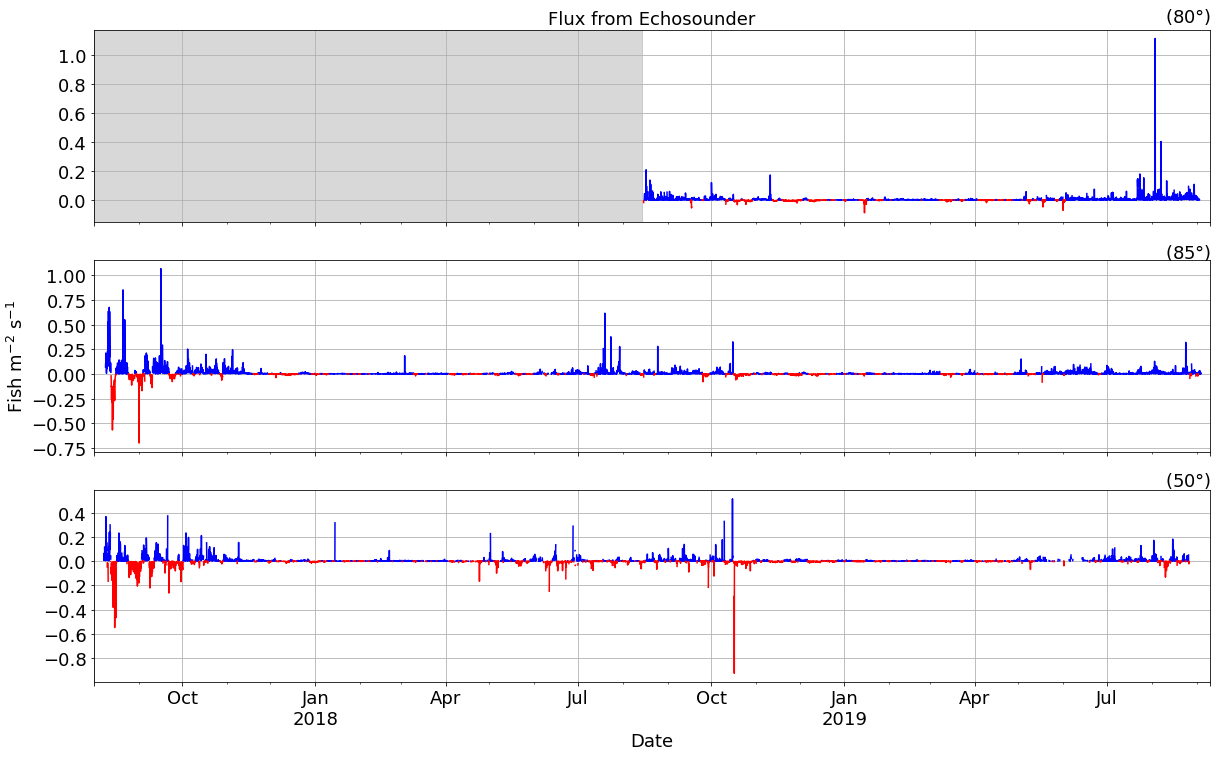

In [41]:
f, [ax1,ax2,ax3] = plt.subplots(3,1,figsize=(20,12),sharex=True, sharey=True)

ax1=plt.subplot(311)
a = df3Comb
a.fv.where(a.fv.ge(0), np.nan).plot(color='blue',axes=ax1,fontsize=18)
a.fv.where(a.fv.lt(0), np.nan).plot(color='red', axes=ax1,fontsize=18)
ax1.axvspan(pd.to_datetime('2017-8-01'), pd.to_datetime('2018-8-14'), ymin=-60, ymax=3000, alpha=0.3, color='grey')
ax1.set_xlim([pd.to_datetime('2017-8-01'),pd.to_datetime('2019-9-10')])
ax1.grid()
ax1.text(pd.to_datetime('2019-08-10'),a.fv.max()*1.1,str('('+str(int(np.max(a.linearHead- a.rotateHead)))+'$\degree$)'),fontsize=18)
ax1.set_xticklabels([])
ax1.xaxis.label.set_visible(False)
plt.title('Flux from Echosounder',fontsize=18)


col = 'tomato'
ax2=plt.subplot(312)
a = df2Comb
a.fv.where(a.fv.ge(0), np.nan).plot(color='blue',axes=ax2,fontsize=18)
a.fv.where(a.fv.lt(0), np.nan).plot(color='red', axes=ax2,fontsize=18)
#a.resample('D').mean().plot(legend=False,label='Daily Mean', axes=ax1,linewidth=2,color='k')
#if pltDict[df.name][0]==1:
#    ax1.axvspan(pd.to_datetime('2017-8-01'), pd.to_datetime('2018-8-14'), ymin=-60, ymax=3000, alpha=0.3, color='grey')
#ax1.set_ylim([-60,pltDict[df.name][2]])
##ax1.set_yticks([0,1000,2000,3000])
ax2.set_xlim([pd.to_datetime('2017-8-01'),pd.to_datetime('2019-9-10')])
ax2.grid()
ax2.text(pd.to_datetime('2019-08-10'),a.fv.max()*1.1,str('('+str(int(np.max(a.linearHead- a.rotateHead)))+'$\degree$)'),fontsize=18)
#ax1.legend(['Wakeup Mean','Daily Mean'], fontsize=18)
ax2.set_xticklabels([])
ax2.xaxis.label.set_visible(False)
plt.ylabel('Fish m$^{-2}$ s$^{-1}$',fontsize=18)

col = 'tomato'
ax3=plt.subplot(313)
a = df1Comb
a.fv.where(a.fv.ge(0), np.nan).plot(color='blue',axes=ax3,fontsize=18)
a.fv.where(a.fv.lt(0), np.nan).plot(color='red', axes=ax3,fontsize=18)
#a.resample('D').mean().plot(legend=False,label='Daily Mean', axes=ax1,linewidth=2,color='k')
#if pltDict[df.name][0]==1:
#    ax1.axvspan(pd.to_datetime('2017-8-01'), pd.to_datetime('2018-8-14'), ymin=-60, ymax=3000, alpha=0.3, color='grey')
#ax1.set_ylim([-60,pltDict[df.name][2]])
##ax1.set_yticks([0,1000,2000,3000])
ax3.set_xlim([pd.to_datetime('2017-8-01'),pd.to_datetime('2019-9-10')])
ax3.grid()
ax3.text(pd.to_datetime('2019-08-10'),a.fv.max()*1.2,str('('+str(int(np.max(a.linearHead- a.rotateHead)))+'$\degree$)'),fontsize=18)
#ax1.legend(['Wakeup Mean','Daily Mean'], fontsize=18)
#ax1.set_xticklabels([])
#ax1.xaxis.label.set_visible(False)
#plt.ylabel('70 kHz Backscatter\n(s$_{A}$, m$^{2}$ nmi$^{-2}$)',fontsize=16)
plt.xlabel('Date',fontsize=18)

Text(0.5, 0, 'Date')

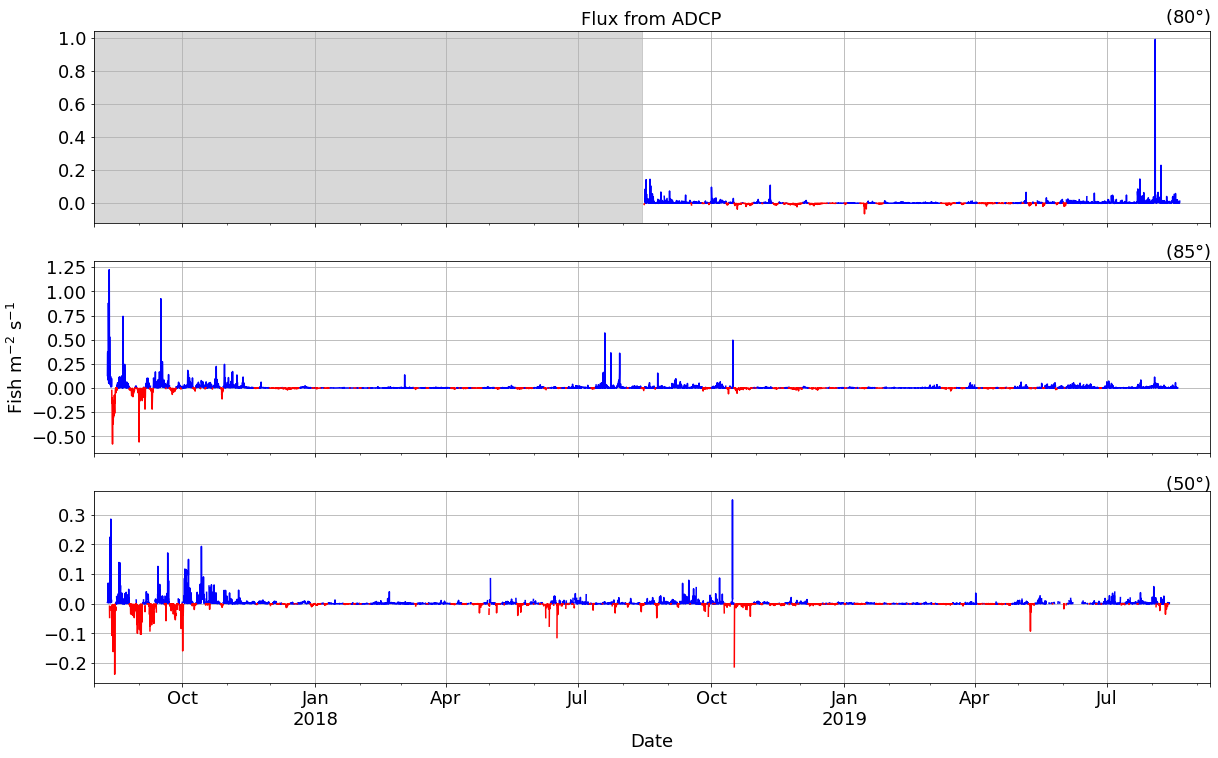

In [42]:
f, [ax1,ax2,ax3] = plt.subplots(3,1,figsize=(20,12),sharex=True, sharey=True)

ax1=plt.subplot(311)
a = df3Comb
a.fvADCP.where(a.fvADCP.ge(0), np.nan).plot(color='blue',axes=ax1,fontsize=18)
a.fvADCP.where(a.fvADCP.lt(0), np.nan).plot(color='red', axes=ax1,fontsize=18)
ax1.axvspan(pd.to_datetime('2017-8-01'), pd.to_datetime('2018-8-14'), ymin=-60, ymax=3000, alpha=0.3, color='grey')
ax1.set_xlim([pd.to_datetime('2017-8-01'),pd.to_datetime('2019-9-10')])
ax1.grid()
ax1.set_xticklabels([])
ax1.xaxis.label.set_visible(False)
ax1.text(pd.to_datetime('2019-08-10'),a.fvADCP.max()*1.1,str('('+str(int(np.max(a.linearHead- a.rotateHead)))+'$\degree$)'),fontsize=18)
plt.title('Flux from ADCP',fontsize=18)

col = 'tomato'
ax2=plt.subplot(312)
a = df2Comb
a.fvADCP.where(a.fvADCP.ge(0), np.nan).plot(color='blue',axes=ax2,fontsize=18)
a.fvADCP.where(a.fvADCP.lt(0), np.nan).plot(color='red', axes=ax2,fontsize=18)
#a.resample('D').mean().plot(legend=False,label='Daily Mean', axes=ax1,linewidth=2,color='k')
#if pltDict[df.name][0]==1:
#    ax1.axvspan(pd.to_datetime('2017-8-01'), pd.to_datetime('2018-8-14'), ymin=-60, ymax=3000, alpha=0.3, color='grey')
#ax1.set_ylim([-60,pltDict[df.name][2]])
##ax1.set_yticks([0,1000,2000,3000])
ax2.set_xlim([pd.to_datetime('2017-8-01'),pd.to_datetime('2019-9-10')])
ax2.grid()
#ax1.legend(['Wakeup Mean','Daily Mean'], fontsize=18)
ax2.set_xticklabels([])
ax2.xaxis.label.set_visible(False)
ax2.text(pd.to_datetime('2019-08-10'),a.fvADCP.max()*1.1,str('('+str(int(np.max(a.linearHead- a.rotateHead)))+'$\degree$)'),fontsize=18)
plt.ylabel('Fish m$^{-2}$ s$^{-1}$',fontsize=18)

col = 'tomato'
ax3=plt.subplot(313)
a = df1Comb
a.fvADCP.where(a.fvADCP.ge(0), np.nan).plot(color='blue',axes=ax3,fontsize=18)
a.fvADCP.where(a.fvADCP.lt(0), np.nan).plot(color='red', axes=ax3,fontsize=18)
#a.resample('D').mean().plot(legend=False,label='Daily Mean', axes=ax1,linewidth=2,color='k')
#if pltDict[df.name][0]==1:
#    ax1.axvspan(pd.to_datetime('2017-8-01'), pd.to_datetime('2018-8-14'), ymin=-60, ymax=3000, alpha=0.3, color='grey')
#ax1.set_ylim([-60,pltDict[df.name][2]])
##ax1.set_yticks([0,1000,2000,3000])
ax3.set_xlim([pd.to_datetime('2017-8-01'),pd.to_datetime('2019-9-10')])
ax3.grid()
ax3.text(pd.to_datetime('2019-08-10'),a.fvADCP.max()*1.1,str('('+str(int(np.max(a.linearHead- a.rotateHead)))+'$\degree$)'),fontsize=18)
plt.xlabel('Date',fontsize=18)
#ax1.legend(['Wakeup Mean','Daily Mean'], fontsize=18)
#ax1.set_xticklabels([])
#ax1.xaxis.label.set_visible(False)


(<matplotlib.patches.Rectangle at 0x1c5852083a0>,
 (<matplotlib.patches.ConnectionPatch at 0x1c58520d6d0>,
  <matplotlib.patches.ConnectionPatch at 0x1c5852089a0>))

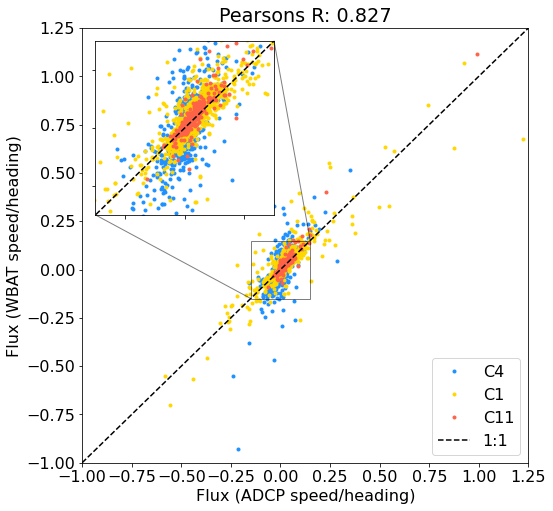

In [43]:
plt.rcParams['font.size'] = 16
fig = plt.figure(figsize = (8,8))
ax = plt.subplot(111)
ax.plot(df1Comb.fvADCP, df1Comb.fv,'.',color='dodgerblue')
ax.plot(df2Comb.fvADCP, df2Comb.fv,'.',color='gold')
ax.plot(df3Comb.fvADCP, df3Comb.fv,'.',color='tomato')
ax.axis([-1,1.25,-1,1.25])
ax.plot([-1,1.25],[-1,1.25],'--k')
ax.set_xlabel('Flux (ADCP speed/heading)')
ax.set_ylabel('Flux (WBAT speed/heading)')
plt.legend(['C4','C1','C11','1:1'])
pr = np.round(np.corrcoef(np.concatenate([df1Comb.dropna().fvADCP,df2Comb.dropna().fvADCP,df3Comb.dropna().fvADCP]),np.concatenate([df1Comb.dropna().fv,df2Comb.dropna().fv,df3Comb.dropna().fv]))[0][1],3)
plt.title('Pearsons R: '+str(pr))


axins = ax.inset_axes([0.03, 0.57, 0.4, 0.4])
axins.plot(df1Comb.fvADCP, df1Comb.fv,'.',color='dodgerblue')
axins.plot(df2Comb.fvADCP, df2Comb.fv,'.',color='gold')
axins.plot(df3Comb.fvADCP, df3Comb.fv,'.',color='tomato')
axins.plot([-1,1.25],[-1,1.25],'--k')
# sub region of the original image
x1, x2, y1, y2 = -.15,.15,-.15,.15
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
axins.set_xticklabels('')
axins.set_yticklabels('')

ax.indicate_inset_zoom(axins, edgecolor="black")

In [46]:
df1Comb = combF(dfD1,dfD1T, dfD1ADCP,1)#47)
df2Comb = combF(dfD2,dfD2T, dfD2ADCP,1)#44)
df3Comb = combF(dfD3,dfD3T, dfD3ADCP,1)#49)

uf = glob('../data/physicalData/wind/uwnd*')
vf = glob('../data/physicalData/wind/vwnd*')
dsU = xr.open_mfdataset(uf)
dsV = xr.open_mfdataset(vf)
dsWind = dsU.merge(dsV)
dsWind.sel(lat=70,lon=195)
dfWind =dsWind.sel(lat=70,lon=195).to_dataframe()

Text(0.5, 0, 'Date')

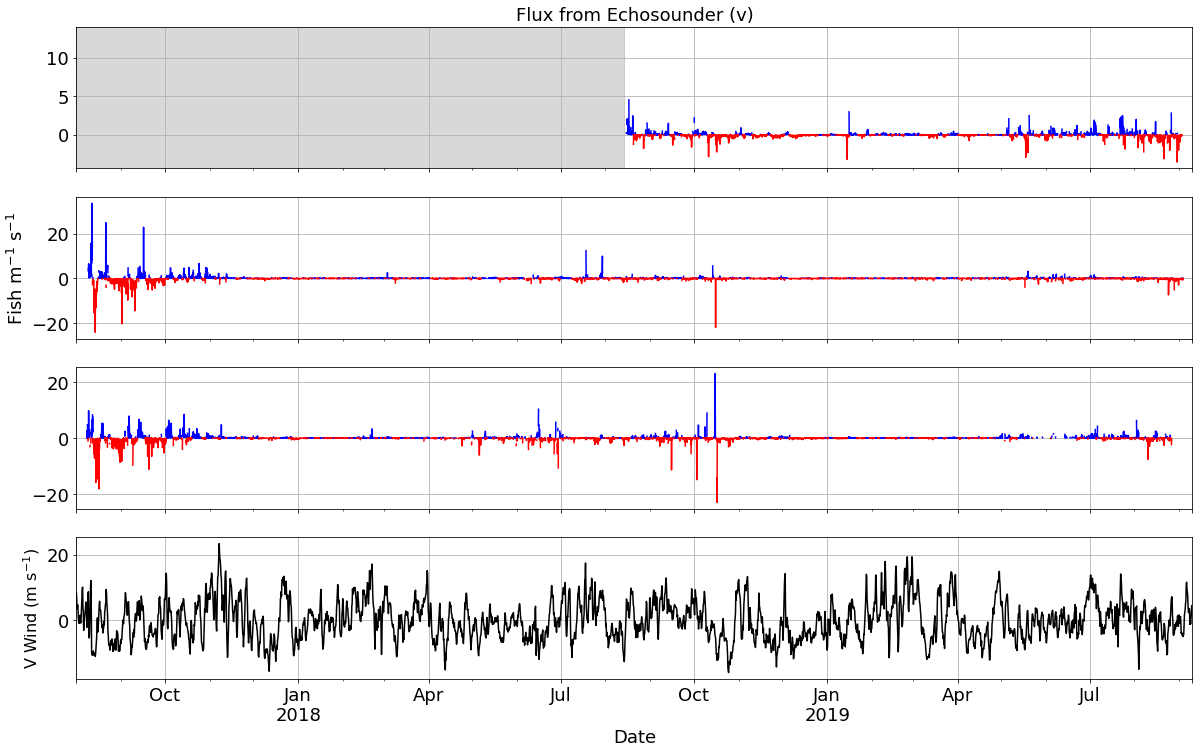

In [59]:
f, [ax1,ax2,ax3,ax4] = plt.subplots(4,1,figsize=(20,12),sharex=True, sharey=True)

ax1=plt.subplot(411)
a = df3Comb
a.fv.where(a.fv.ge(0), np.nan).plot(color='blue',axes=ax1,fontsize=18)
a.fv.where(a.fv.lt(0), np.nan).plot(color='red', axes=ax1,fontsize=18)
ax1.axvspan(pd.to_datetime('2017-8-01'), pd.to_datetime('2018-8-14'), ymin=-60, ymax=3000, alpha=0.3, color='grey')
ax1.set_xlim([pd.to_datetime('2017-8-01'),pd.to_datetime('2019-9-10')])
ax1.grid()
ax1.set_xticklabels([])
ax1.xaxis.label.set_visible(False)
plt.title('Flux from Echosounder (v)',fontsize=18)


col = 'tomato'
ax2=plt.subplot(412)
a = df2Comb
a.fv.where(a.fv.ge(0), np.nan).plot(color='blue',axes=ax2,fontsize=18)
a.fv.where(a.fv.lt(0), np.nan).plot(color='red', axes=ax2,fontsize=18)
#a.resample('D').mean().plot(legend=False,label='Daily Mean', axes=ax1,linewidth=2,color='k')
#if pltDict[df.name][0]==1:
#    ax1.axvspan(pd.to_datetime('2017-8-01'), pd.to_datetime('2018-8-14'), ymin=-60, ymax=3000, alpha=0.3, color='grey')
#ax1.set_ylim([-60,pltDict[df.name][2]])
##ax1.set_yticks([0,1000,2000,3000])
ax2.set_xlim([pd.to_datetime('2017-8-01'),pd.to_datetime('2019-9-10')])
ax2.grid()
#ax1.legend(['Wakeup Mean','Daily Mean'], fontsize=18)
ax2.set_xticklabels([])
ax2.xaxis.label.set_visible(False)
plt.ylabel('Fish m$^{-1}$ s$^{-1}$',fontsize=18)

col = 'tomato'
ax3=plt.subplot(413)
a = df1Comb
a.fv.where(a.fv.ge(0), np.nan).plot(color='blue',axes=ax3,fontsize=18)
a.fv.where(a.fv.lt(0), np.nan).plot(color='red', axes=ax3,fontsize=18)
#a.resample('D').mean().plot(legend=False,label='Daily Mean', axes=ax1,linewidth=2,color='k')
#if pltDict[df.name][0]==1:
#    ax1.axvspan(pd.to_datetime('2017-8-01'), pd.to_datetime('2018-8-14'), ymin=-60, ymax=3000, alpha=0.3, color='grey')
#ax1.set_ylim([-60,pltDict[df.name][2]])
##ax1.set_yticks([0,1000,2000,3000])
ax3.set_xlim([pd.to_datetime('2017-8-01'),pd.to_datetime('2019-9-10')])
ax3.grid()
#ax1.legend(['Wakeup Mean','Daily Mean'], fontsize=18)
ax3.set_xticklabels([])
ax3.xaxis.label.set_visible(False)
#plt.ylabel('70 kHz Backscatter\n(s$_{A}$, m$^{2}$ nmi$^{-2}$)',fontsize=16)

ax4=plt.subplot(414)
dfWind.vwnd.plot(label='Wakeups',legend=False,fontsize='18',axes=ax4, color='k')
ax4.set_xlim([pd.to_datetime('2017-8-01'),pd.to_datetime('2019-9-10')])
ax4.grid()
ax4.set_ylabel('V Wind (m s$^{-1}$)')
plt.xlabel('Date',fontsize=18)

Text(0.5, 0, 'Date')

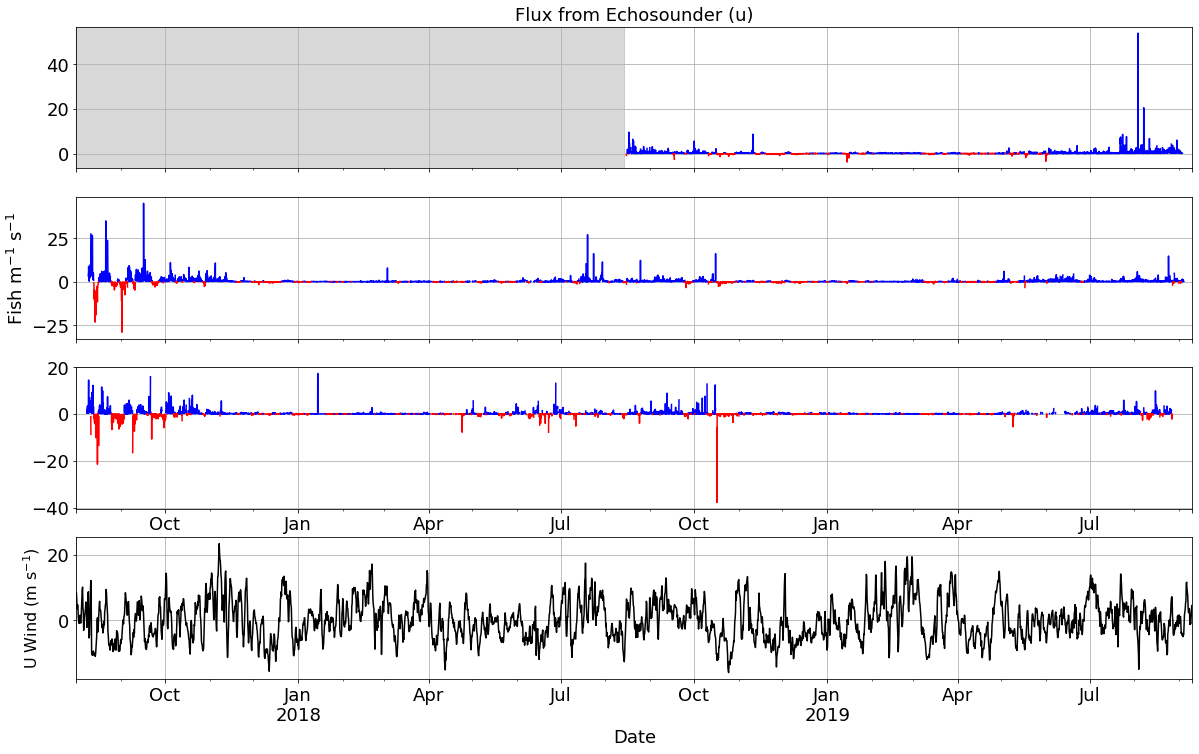

In [61]:
f, [ax1,ax2,ax3,ax4] = plt.subplots(4,1,figsize=(20,12),sharex=True, sharey=True)

ax1=plt.subplot(411)
a = df3Comb
a.fu.where(a.fu.ge(0), np.nan).plot(color='blue',axes=ax1,fontsize=18)
a.fu.where(a.fu.lt(0), np.nan).plot(color='red', axes=ax1,fontsize=18)
ax1.axvspan(pd.to_datetime('2017-8-01'), pd.to_datetime('2018-8-14'), ymin=-60, ymax=3000, alpha=0.3, color='grey')
ax1.set_xlim([pd.to_datetime('2017-8-01'),pd.to_datetime('2019-9-10')])
ax1.grid()
ax1.set_xticklabels([])
ax1.xaxis.label.set_visible(False)
plt.title('Flux from Echosounder (u)',fontsize=18)


col = 'tomato'
ax2=plt.subplot(412)
a = df2Comb
a.fu.where(a.fu.ge(0), np.nan).plot(color='blue',axes=ax2,fontsize=18)
a.fu.where(a.fu.lt(0), np.nan).plot(color='red', axes=ax2,fontsize=18)
#a.resample('D').mean().plot(legend=False,label='Daily Mean', axes=ax1,linewidth=2,color='k')
#if pltDict[df.name][0]==1:
#    ax1.axvspan(pd.to_datetime('2017-8-01'), pd.to_datetime('2018-8-14'), ymin=-60, ymax=3000, alpha=0.3, color='grey')
#ax1.set_ylim([-60,pltDict[df.name][2]])
##ax1.set_yticks([0,1000,2000,3000])
ax2.set_xlim([pd.to_datetime('2017-8-01'),pd.to_datetime('2019-9-10')])
ax2.grid()
#ax1.legend(['Wakeup Mean','Daily Mean'], fontsize=18)
ax2.set_xticklabels([])
ax2.xaxis.label.set_visible(False)
plt.ylabel('Fish m$^{-1}$ s$^{-1}$',fontsize=18)

col = 'tomato'
ax3=plt.subplot(413)
a = df1Comb
a.fu.where(a.fu.ge(0), np.nan).plot(color='blue',axes=ax3,fontsize=18)
a.fu.where(a.fu.lt(0), np.nan).plot(color='red', axes=ax3,fontsize=18)
#a.resample('D').mean().plot(legend=False,label='Daily Mean', axes=ax1,linewidth=2,color='k')
#if pltDict[df.name][0]==1:
#    ax1.axvspan(pd.to_datetime('2017-8-01'), pd.to_datetime('2018-8-14'), ymin=-60, ymax=3000, alpha=0.3, color='grey')
#ax1.set_ylim([-60,pltDict[df.name][2]])
##ax1.set_yticks([0,1000,2000,3000])
ax3.set_xlim([pd.to_datetime('2017-8-01'),pd.to_datetime('2019-9-10')])
ax3.grid()
#ax1.legend(['Wakeup Mean','Daily Mean'], fontsize=18)
#ax1.set_xticklabels([])
#ax1.xaxis.label.set_visible(False)
#plt.ylabel('70 kHz Backscatter\n(s$_{A}$, m$^{2}$ nmi$^{-2}$)',fontsize=16)
plt.xlabel('Date',fontsize=18)

ax4=plt.subplot(414)
dfWind.vwnd.plot(label='Wakeups',legend=False,fontsize='18',axes=ax4, color='k')
ax4.set_xlim([pd.to_datetime('2017-8-01'),pd.to_datetime('2019-9-10')])
ax4.grid()
ax4.set_ylabel('U Wind (m s$^{-1}$)')
plt.xlabel('Date',fontsize=18)

## Cross-correlation

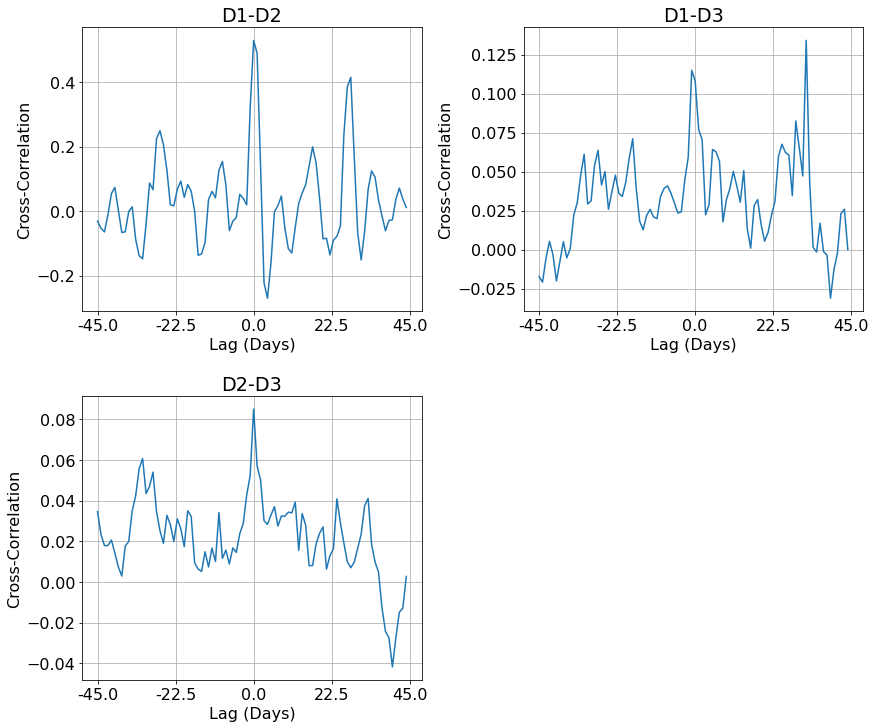

In [749]:
dfvs = df1Comb[['fvADCP']].rename(columns={'fvADCP':'fvADCP1'}).join(df2Comb[['fvADCP']].rename(columns={'fvADCP':'fvADCP2'})).join(df3Comb[['fvADCP']].rename(columns={'fvADCP':'fvADCP3'}))
def crosscorr(datax, datay, lag=0, wrap=False):
    """ Lag-N cross correlation. 
    Shifted data filled with NaNs 
    
    Parameters
    ----------
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length
    Returns
    ----------
    crosscorr : float
    """
    if wrap:
        shiftedy = datay.shift(lag)
        shiftedy.iloc[:lag] = datay.iloc[-lag:].values
        return datax.corr(shiftedy)
    else: 
        return datax.corr(datay.shift(lag))

    

days = 45

fig = plt.figure(figsize=(14,12))

d1 = dfvs.fvADCP1.resample('1D').sum()
d2 = dfvs.fvADCP2.resample('1D').sum()
rs = [crosscorr(d1,d2, lag) for lag in range(-days,days)]
ax = plt.subplot(221)
ax.plot(rs)
ax.set_xticks(np.arange(0,(days*2)+1,days/2))
ax.set_xticklabels([str(a) for a in np.arange(-days,(days)+1,days/2)]);
ax.set_ylabel('Cross-Correlation')
ax.set_xlabel('Lag (Days)')
ax.grid()
plt.title('D1-D2')

d1 = dfvs.fvADCP1.resample('1D').sum()
d2 = dfvs.fvADCP3.resample('1D').sum()
rs = [crosscorr(d1,d2, lag) for lag in range(-days,days)]
ax = plt.subplot(222)
ax.plot(rs)
ax.set_xticks(np.arange(0,(days*2)+1,days/2))
ax.set_xticklabels([str(a) for a in np.arange(-days,(days)+1,days/2)]);
ax.set_ylabel('Cross-Correlation')
ax.set_xlabel('Lag (Days)')
ax.grid()
plt.title('D1-D3')


d1 = dfvs.fvADCP2.resample('1D').sum()
d2 = dfvs.fvADCP3.resample('1D').sum()
rs = [crosscorr(d1,d2, lag) for lag in range(-days,days)]
ax = plt.subplot(223)
ax.plot(rs)
ax.set_xticks(np.arange(0,(days*2)+1,days/2))
ax.set_xticklabels([str(a) for a in np.arange(-days,(days)+1,days/2)]);
ax.set_ylabel('Cross-Correlation')
ax.set_xlabel('Lag (Days)')
ax.grid()
plt.title('D2-D3')
plt.subplots_adjust(wspace=0.3,hspace=0.3)

Text(0.5, 1.0, 'D2-D3')

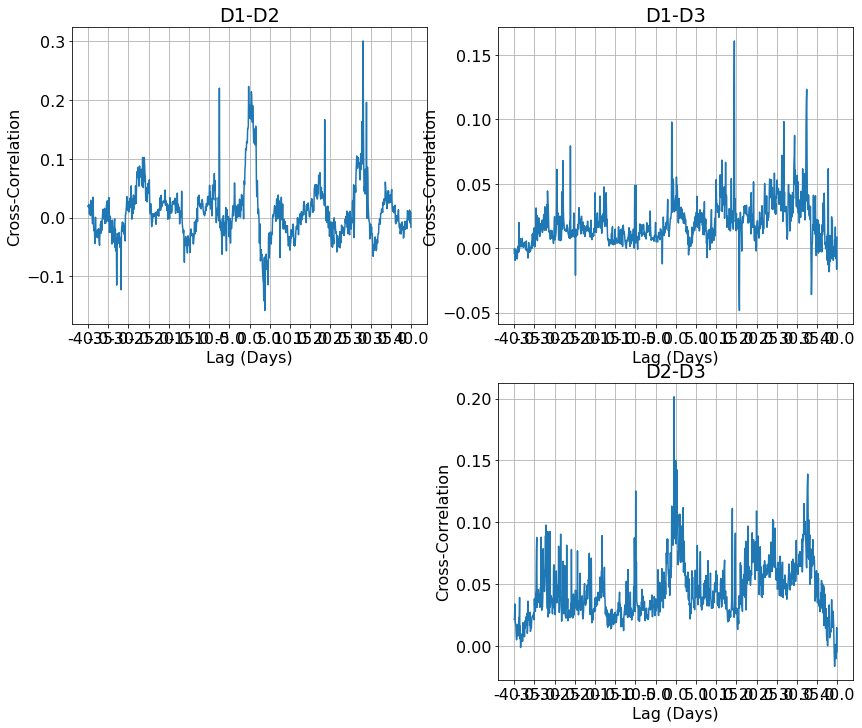

In [750]:
days = 40

fig = plt.figure(figsize=(14,12))

d1 = dfvs.fvADCP1
d2 = dfvs.fvADCP2
rs = [crosscorr(d1,d2, lag) for lag in range(-days*12,days*12)]
ax = plt.subplot(221)
ax.plot(rs)
ax.set_xticks(np.arange(0,(days*12*2)+1,60))
ax.set_xticklabels([str(a) for a in np.arange(-days*12,(days*12)+1,60)/12]);
ax.set_ylabel('Cross-Correlation')
ax.set_xlabel('Lag (Days)')
ax.grid()
plt.title('D1-D2')

d1 = dfvs.fvADCP1
d2 = dfvs.fvADCP3
rs = [crosscorr(d1,d2, lag) for lag in range(-days*12,days*12)]
ax = plt.subplot(222)
ax.plot(rs)
ax.set_xticks(np.arange(0,(days*12*2)+1,60))
ax.set_xticklabels([str(a) for a in np.arange(-days*12,(days*12)+1,60)/12]);
ax.set_ylabel('Cross-Correlation')
ax.set_xlabel('Lag (Days)')
ax.grid()
plt.title('D1-D3')


d1 = dfvs.fvADCP2
d2 = dfvs.fvADCP3
rs = [crosscorr(d1,d2, lag) for lag in range(-days*12,days*12)]
ax = plt.subplot(224)
ax.plot(rs)
ax.set_xticks(np.arange(0,(days*12*2)+1,60))
ax.set_xticklabels([str(a) for a in np.arange(-days*12,(days*12)+1,60)/12]);
ax.set_ylabel('Cross-Correlation')
ax.set_xlabel('Lag (Days)')
ax.grid()
plt.title('D2-D3')